In [1]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn
import csv
import pandas as pd

import dataset
import datasplit
import model.models as models
import trainer
import utils

# TEST on MONO CONTINUOUS

In [2]:
# LOAD
# folders
models_folder = '../../saved/models'
model_name = '20201024_fxnet_mono_cont_best'
results_folder = '../../saved/results'
results_subfolder = '20201024_fxnet_mono_cont'

# model
fxnet = torch.load('%s/%s' % (models_folder, model_name), map_location=torch.device('cpu'))

# results
all_train_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_train_losses.npy')), allow_pickle=True)
all_train_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_train_correct.npy')), allow_pickle=True)
best_train_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_train_results.npy')), allow_pickle=True)

all_val_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_val_losses.npy')), allow_pickle=True)
all_val_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_val_correct.npy')), allow_pickle=True)
best_val_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_val_results.npy')), allow_pickle=True)

all_test_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_test_losses.npy')), allow_pickle=True)
all_test_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_test_correct.npy')), allow_pickle=True)
best_test_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_test_results.npy')), allow_pickle=True)

fx_labels = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'fx_labels.npy')), allow_pickle=True)

# datasets size
train_set_size = best_train_results.shape[0]
val_set_size = best_val_results.shape[0]
test_set_size = best_test_results.shape[0]

# example
best_train_results[0]

array(['123956', 'G93-65506-VTB-F7.1-21197', '12', '12'], dtype='<U28')

In [3]:
# # BEST RESULTS
# print('Best Train Accuracy: ', 100 * max(all_train_correct) / train_set_size)
# print('Epoch: ', np.argmax(all_train_correct))
# print()
# print('Best Val Accuracy: ', 100 * max(all_val_correct) / val_set_size)
# print('Epoch: ', np.argmax(all_val_correct))
# print()
# print('Best Test Accuracy: ', 100 * max(all_test_correct) / test_set_size)
# print('Epoch: ', np.argmax(all_test_correct))
# print()

# # LOSS
# epochs = range(0, len(all_train_losses))
# plt.figure(figsize=(8,6))
# plt.grid(b=None, which='major', axis='both')
# plt.plot(epochs, all_train_losses, 'b', label='Train loss')
# plt.plot(epochs, all_val_losses, 'r', label='Validation loss')
# plt.plot(epochs, all_test_losses, 'g', label='Test loss')
# plt.title('Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # NORMALISED LOSS
# epochs = range(0, len(all_train_losses))
# plt.figure(figsize=(8,6))
# plt.grid(b=None, which='major', axis='both')
# plt.plot(epochs, np.array(all_train_losses) / max(all_train_losses), 'b', label='Train loss')
# plt.plot(epochs, np.array(all_val_losses) / max(all_val_losses), 'r', label='Validation loss')
# plt.plot(epochs, np.array(all_test_losses) / max(all_test_losses), 'g', label='Test loss')
# plt.title('Normalised Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # ACCURACY
# all_train_perc_correct = 100 * np.array(all_train_correct) / train_set_size
# all_val_perc_correct = 100 * np.array(all_val_correct) / val_set_size
# all_test_perc_correct = 100 * np.array(all_test_correct) / test_set_size
# epochs = range(0, len(all_train_losses))
# plt.figure(figsize=(8,6))
# plt.grid(b=None, which='major', axis='both')
# plt.plot(epochs, all_train_perc_correct, 'b', label='Train loss')
# plt.plot(epochs, all_val_perc_correct, 'r', label='Validation loss')
# plt.plot(epochs, all_test_perc_correct, 'g', label='Test loss')
# plt.title('Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

Best Validation Accuracy:  91.32692307692308 at epoch  67
Training Accuracy:  92.88568376068376
Test Accuracy:  90.84615384615384


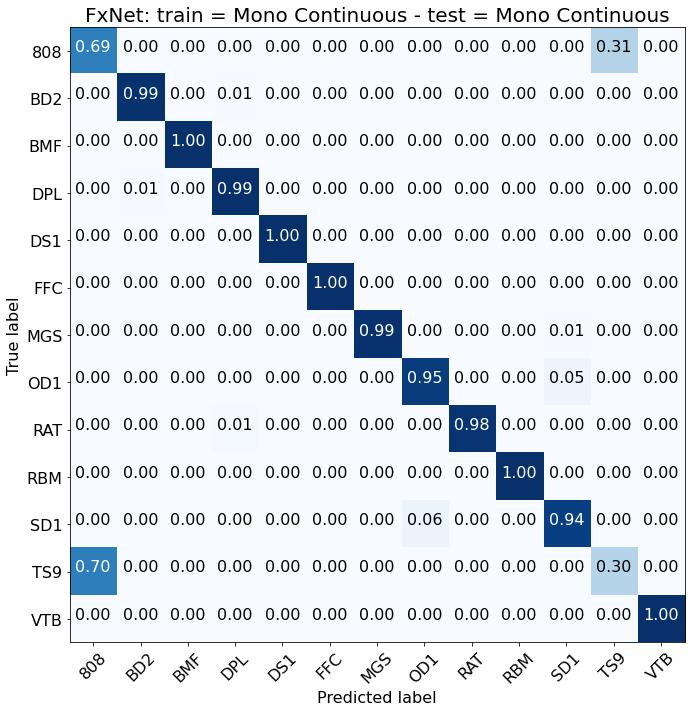

In [4]:
# CONFUSION MATRIX

# Find best performance epoch based on validation
best_val = 100 * max(all_val_correct) / val_set_size
best_val_idx = np.argmax(all_val_correct)

print("Best Validation Accuracy: ",best_val, "at epoch ", best_val_idx)
print("Training Accuracy: ", 100 * all_train_correct[best_val_idx] / train_set_size)
print("Test Accuracy: ", 100 * all_test_correct[best_val_idx] / test_set_size)

# extract predictions and targets vectors
train_preds = best_train_results[:, 2]
train_targets = best_train_results[:, 3]
val_preds = best_val_results[:, 2]
val_targets = best_val_results[:, 3]
test_preds = best_test_results[:, 2]
test_targets = best_test_results[:, 3]

# calculate
train_cm = confusion_matrix(y_true=train_targets, y_pred=train_preds, labels=['0','1','2','3','4','5','6','7','8','9','10','11','12'])
val_cm = confusion_matrix(y_true=val_targets, y_pred=val_preds, labels=['0','1','2','3','4','5','6','7','8','9','10','11','12'])
test_cm = confusion_matrix(y_true=test_targets, y_pred=test_preds, labels=['0','1','2','3','4','5','6','7','8','9','10','11','12'])

# plot
plt.figure(figsize=(10,10))
utils.plot_confusion_matrix(test_cm, fx_labels, normalize=True, title='FxNet: train = Mono Continuous - test = Mono Continuous', title_fontsize=20, text_fontsize=16)
# plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'fxnet_cm_MC_MC.eps'), format='eps')

# TEST on MONO DISCRETE

In [5]:
# dataset
dataset_mono_disc = dataset.FxDataset(
    root='/Volumes/Macintosh HD/DATASETS/GUITAR-FX/Mono_Discrete',
    excl_folders=['NoFX_mono', 'NoFX_mono_preprocessed', 'MT2'], 
    spectra_folder='mel_22050_1024_512', 
    processed_settings_csv='proc_settings.csv',
    max_num_settings=3,
    transform=transforms.Compose([transforms.ToTensor()])
)

# initialise
dataset_mono_disc.init_dataset()
# generate features - necessary only the first time
# dataset_mono_disc.generate_mel()

# split
# set test_train_split=0.0 and val_train_split=0.0 to test pre-trained model
split_mono_disc = datasplit.DataSplit(dataset_mono_disc, test_train_split=0.0, val_train_split=0.0, shuffle=True)

# loaders
_, _, test_loader_mono_disc = split_mono_disc.get_split(batch_size=100)

len(dataset_mono_disc)

123552

In [6]:
# TEST
test_mono_disc_loss, test_mono_disc_correct, test_mono_disc_results = trainer.test_fx_net(
    model=fxnet, 
    test_loader=test_loader_mono_disc, 
    test_sampler=split_mono_disc.test_sampler,
    loss_function=nn.CrossEntropyLoss(), 
    device='cpu'
)

====> Test Loss: 2229.7371	 Avg Loss: 0.0180	Correct: 100494/123552	Percentage Correct: 81.34


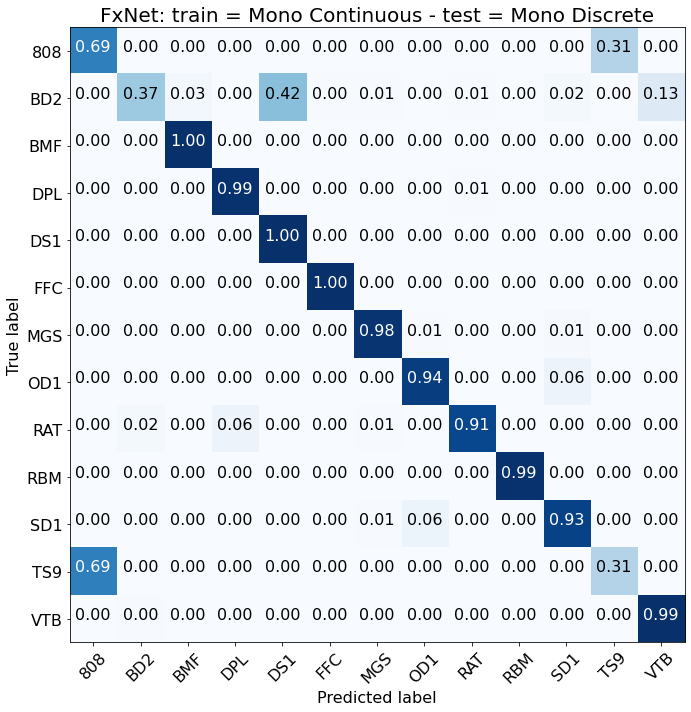

In [7]:
# results
test_mono_disc_preds = np.array(test_mono_disc_results)[:, 2]
test_mono_disc_targets = np.array(test_mono_disc_results)[:, 3]

# calculate conf. matrix
test_mono_disc_cm = confusion_matrix(y_true=test_mono_disc_targets, y_pred=test_mono_disc_preds, labels=['0','1','2','3','4','5','6','7','8','9','10','11','12'])

# plot
plt.figure(figsize=(10,10))
utils.plot_confusion_matrix(test_mono_disc_cm, fx_labels, normalize=True, title='FxNet: train = Mono Continuous - test = Mono Discrete', title_fontsize=20, text_fontsize=16)
# plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'fxnet_cm_MC_MD.eps'), format='eps')